<a href="https://colab.research.google.com/github/MallaRaraju/DP3_Jr.NTR_detection/blob/main/Jr_NTR_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing dependencies

In [1]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as aug
import os
import cv2
import json

In [3]:
# importing roboflow for dataset
!pip install roboflow
from roboflow import Roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=93d608d5c01e9bc25ed36b29ea44b79981451f17814273abdd917816d97695d8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
   

In [4]:
from tensorflow import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalMaxPooling2D, Input, MaxPooling2D
from keras.models import Model
from keras.applications import VGG16

# Loading data

In [5]:
rf = Roboflow(api_key="8OAIvpA0eeCXebsfWJ4U")
project = rf.workspace("malla-raraju-umx2i").project("celebrity-z8hhd")
dataset = project.version(4).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Celebrity-4 in coco:: 100%|██████████| 101/101 [00:00<00:00, 3226.71it/s]


# Data augmentation

In [7]:
augmentor = aug.Compose([aug.RandomCrop(width = 120, height = 120),
                         aug.HorizontalFlip(p=0.5),
                         aug.RandomBrightnessContrast(p=0.2),
                         aug.RandomGamma(p=0.2),
                         aug.VerticalFlip(p=0.5),
                         aug.RGBShift(p=0.2)],
                        bbox_params=aug.BboxParams(format='coco',
                                                    label_fields=['class_labels']))

Let's see an augmented image

In [8]:
with open('/content/Celebrity-4/train/_annotations.coco.json') as f:
  annot = json.load(f)

In [10]:
#annot['annotations'].remove(annot['annotations'][18])
#annot['annotations'].remove(annot['annotations'][19])

In [9]:
annot['annotations'][19]

{'id': 19,
 'image_id': 21,
 'category_id': 1,
 'bbox': [114, 5, 70.87, 108.73],
 'area': 7705.695,
 'segmentation': [],
 'iscrowd': 0}

In [11]:
annot['annotations']

[{'id': 0,
  'image_id': 1,
  'category_id': 1,
  'bbox': [4, 49, 34.74, 43.26],
  'area': 1502.852,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 2,
  'category_id': 1,
  'bbox': [136, 7, 43.22, 59.5],
  'area': 2571.59,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 3,
  'category_id': 1,
  'bbox': [213, 5, 54.77, 61.66],
  'area': 3377.118,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 5,
  'category_id': 1,
  'bbox': [44, 0, 78.34, 97.35],
  'area': 7626.399,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 4,
  'image_id': 6,
  'category_id': 1,
  'bbox': [113, 9, 57.94, 93.24],
  'area': 5402.326,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 5,
  'image_id': 7,
  'category_id': 1,
  'bbox': [148, 1, 52.43, 78.13],
  'area': 4096.356,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 6,
  'image_id': 8,
  'category_id': 1,
  'bbox': [108, 3, 99.69, 127.18],
  'area': 12678.574,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 7,
  'i

In [12]:
coords = annot['annotations'][1]['bbox']
img = cv2.imread(os.path.join('/content/Celebrity-4/train',annot['images'][annot['annotations'][1]['image_id']]['file_name']))
class_label = annot['categories'][0]['name']

In [13]:
coords

[136, 7, 43.22, 59.5]

In [20]:
sample_aug = augmentor(image=img, bboxes=[coords], class_labels=[class_label])

In [21]:
sample_aug['bboxes']

[(8.780000000000005, 61.49999999999999, 43.22, 58.50000000000001)]

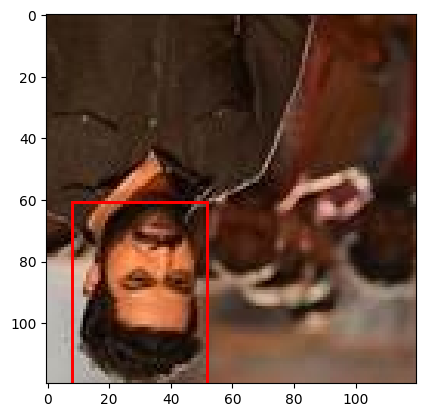

In [22]:
def lets_see(img, min_c, max_c, b_color):
  det = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), min_c, max_c, b_color, 1)
  plt.imshow(det, origin ='upper')
lets_see(sample_aug['image'],tuple(np.array(sample_aug['bboxes'][0][0:2]).astype(int)),tuple(np.add(sample_aug['bboxes'][0][0:2],sample_aug['bboxes'][0][2:]).astype(int)),(255, 0, 0))

In [ ]:
sample_aug['class_labels']

['JrNTR']

# Data augmentation pipeline

In [ ]:
annot['annotations'][-1]

{'id': 54,
 'image_id': 59,
 'category_id': 1,
 'bbox': [59, 19, 53.85, 67.74],
 'area': 3647.799,
 'segmentation': [],
 'iscrowd': 0}

In [23]:
os.remove('/content/Celebrity-4/README.dataset.txt')
os.remove('/content/Celebrity-4/README.roboflow.txt')
aug_dir = '/content/aug_data'
os.mkdir(aug_dir)

In [ ]:
annot.keys(), annot['images'][-1]['id']

(dict_keys(['info', 'licenses', 'categories', 'images', 'annotations']), 58)

In [24]:
len(os.listdir('/content/Celebrity-4/test'))

10

In [25]:
# DataAugmentation pipeline
data_leak = {'test':[],'train':[],'valid':[]}
data_dir = '/content/Celebrity-4'
for sub in ['test', 'train', 'valid']:
    anot_f = os.path.join(data_dir,sub,'_annotations.coco.json') # path foe annotations in the disk
    indx=0 # intiating index to iterate over annotations
    prev_diff=0 # To observe the missing of a -ve sample
    dist_img = [] #| to avoid multiple augmentations of single image with mutiple objects | ------ref_0
                  #| we record each distinct image in this list |
    with open(anot_f) as f:
      f = json.load(f)
      last_annot = f['annotations'][-1]['id'] # recording id of last annotation to break the while loop
      while indx <= last_annot:
        annot_x = f['annotations'][indx] # annotation of an Xth indexed label
        img_id = annot_x['image_id']
        diff = img_id-annot_x['id'] # to check if any image is skipped( or a -ve sample)
        img_path = f['images'][img_id]['file_name']

        if diff>prev_diff: # storing each ignored sample to augment later
          prev_diff+=1
          lk_img = f['images'][img_id-1]['file_name']
          data_leak[sub].append(lk_img)
        elif diff<prev_diff: # refer ref_0
          prev_diff-=1

        if img_id not in dist_img:
          dist_img.append(img_id)
        else:
          indx+=1
          continue

        coords = annot_x['bbox']
        label = annot_x['category_id']

        indx+=1
        try:
          for _ in range(60):
            img = cv2.imread(os.path.join(data_dir,sub,img_path))
            aug_img = augmentor(image=img, bboxes=[coords], class_labels=['Jr.NTR'])

            annotation = {}
            annotation['image'] = img_path

            if len(aug_img['bboxes'])>0:
              annotation['bbox'] = tuple(map(lambda x: x/255, aug_img['bboxes'][0]))
              annotation['class'] = 1
            else:
              annotation['bbox'] = [0, 0, 0, 0]
              annotation['class'] = 0

            if not os.path.exists(os.path.join(aug_dir,sub)):
              os.mkdir(os.path.join(os.path.join(aug_dir,sub)))

            if not os.path.exists(os.path.join(aug_dir,sub,'label')):
              os.mkdir(os.path.join(aug_dir,sub,'label'))
              with open(os.path.join(aug_dir,sub,'label',f'{img_path.split(".")[0]}.{_}.json'), 'w') as o:
                json.dump(annotation, o)
            else:
              with open(os.path.join(aug_dir,sub,'label',f'{img_path.split(".")[0]}.{_}.json'), 'w') as o:
                json.dump(annotation, o)

            if not os.path.exists(os.path.join(aug_dir,sub,'image')):
              os.mkdir(os.path.join(aug_dir,sub,'image'))
              cv2.imwrite(os.path.join(aug_dir,sub,'image',f'{img_path.split(".")[0]}.{_}.jpg'),aug_img['image'])
            else:
              cv2.imwrite(os.path.join(aug_dir,sub,'image',f'{img_path.split(".")[0]}.{_}.jpg'),aug_img['image'])
        except Exception as e:
          print('At image: {} {} occured'.format(img_path,e))

At image: th-95-_jpeg.rf.aadceb3d2007804738cb9cc68972752f.jpg Requested crop size (120, 120) is larger than the image size (180, 119) occured
At image: th-94-_jpeg.rf.cda009c90ac2e98fdd76b910fb80bcd2.jpg Requested crop size (120, 120) is larger than the image size (180, 119) occured
At image: th-96-_jpeg.rf.8e28b62dbe1a37d83be152dfde7a24b9.jpg Requested crop size (120, 120) is larger than the image size (180, 119) occured


In [26]:
# Pushing negative samples into dataset
try:
  coord =[0,0,0.00001,0.00001]
  label = 0
  for i in data_leak:
    for j in data_leak[i]:
      img_path = j
      for _ in range(60):
        img = cv2.imread(os.path.join(data_dir,i,img_path))
        aug_img = augmentor(image=img, bboxes=[coords], class_labels=['Jr.NTR'])

        annotation = {}
        annotation['image'] = img_path

        cv2.imwrite(os.path.join(aug_dir,i,'image',f'{img_path.split(".")[0]}.{_}.jpg'),aug_img['image'])

        annotation['bbox'] = [0, 0, 0, 0]
        annotation['class'] = 0

        with open(os.path.join(aug_dir,i,'label',f'{img_path.split(".")[0]}.{_}.json'), 'w') as o:
          json.dump(annotation, o)
except Exception as e:
  print('At image: {} {} occured'.format(img_path,e))

# Creating data pipeline

In [27]:
# map labels into the data pipeline
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
    label = json.load(f)
  return [label['class'], label['bbox']]

In [28]:
def load_images(image_path):
  byte_img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [29]:
def label_pl(label):
  label_line = tf.data.Dataset.list_files(label, shuffle=False)
  label_line = label_line.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]))
  return label_line

In [30]:
def image_pl(img):
  img_line = tf.data.Dataset.list_files(img, shuffle=False)
  img_line = img_line.map(load_images)
  img_line = img_line.map(lambda x: tf.image.resize(x, (120, 120)))
  img_line = img_line.map(lambda x: x/255)
  return img_line

In [31]:
def data_pl(data):
  data_pl =   tf.data.Dataset.zip(data)
  data_pl =   data_pl.shuffle(int(len(data[0])*1.35))
  data_pl =   data_pl.batch(8)
  data_pl =   data_pl.prefetch(4) # eliminates bottle-necks in data pipeline
  return data_pl

In [32]:
data = [None]*3
img = [None]*3
lbl = [None]*3
i=0
for _ in  ['test', 'train', 'valid']:
  pl_img = image_pl(os.path.join(aug_dir,_,'image','*.jpg'))
  pl_labels = label_pl(os.path.join(aug_dir,_,'label','*.json'))
  img[i] = pl_img
  lbl[i] = pl_labels
  data[i] = data_pl((pl_img,pl_labels))
  i+=1

Checking

In [33]:
def lets_see(img, min_c, max_c, b_color):
  det = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), min_c, max_c, b_color, 1)
  plt.imshow(det, origin ='upper')

In [34]:
batch_data = data[1].as_numpy_iterator()

[0 0] [12 74]
[15  0] [89 97]
[86  0] [119  31]
[16  0] [80 57]
[0 0] [40 30]
[0 0] [42 74]
[79 31] [119 113]


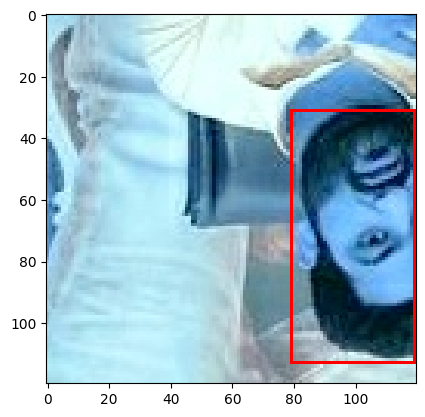

In [37]:
batch = batch_data.next()
imgs = batch[0]
lbls = batch[1][1]
for i in range(8):
  if sum(lbls[i])>0:
    cmin = np.multiply(np.array(lbls[i][0:2]), [255,255]).astype(int)
    cmax = np.multiply(np.add(lbls[i][0:2],lbls[i][2:]), [255, 255]).astype(int)
    print(cmin, cmax)
    lets_see(imgs[i],tuple(cmin),tuple(cmax),(255, 0, 0))

In [38]:
len(data[0]), len(data[1]), len(data[2])

(68, 428, 173)

In [39]:
len(img[0]), len(lbl[0]), len(img[1]), len(lbl[1]), len(img[2]), len(lbl[2])

(540, 540, 3420, 3420, 1380, 1380)

# Build model

## downloading backbone(vgg16)

In [ ]:
vgg16 = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

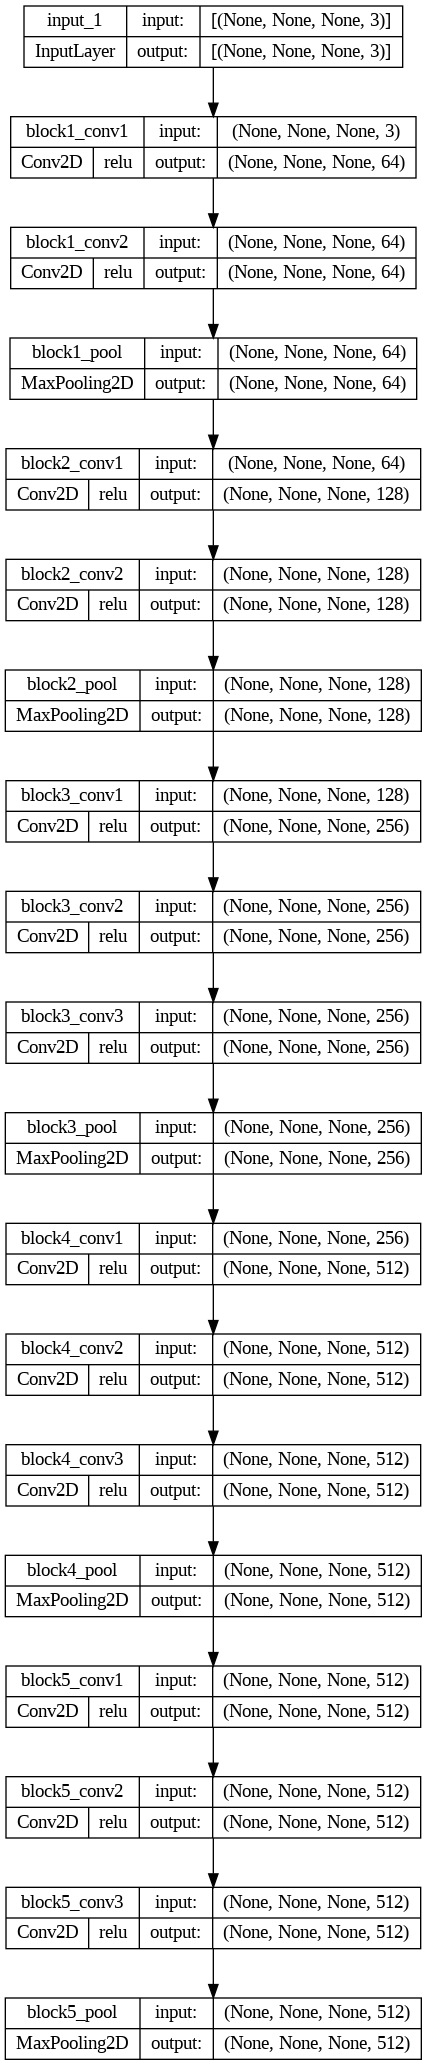

In [ ]:
keras.utils.plot_model(vgg16, show_shapes=True, show_layer_activations=True)

## Making our model's head

In [87]:
def build_model():
  input = Input(shape=(120,120,3))

  vgg16 = VGG16(include_top=False)(input)

  features = Flatten(name = 'feature_map')(vgg16)

  d1 = Dropout(0.4)(features)
  d2 = Dropout(0.4)(features)

  classify_head = Dense(2048, activation='relu', name = 'classification_dense')(d1)
  classify_head = Dense(1, activation = 'sigmoid', name = 'classifying_head')(classify_head)

  regress_head = Dense(2048, activation='relu', name = 'regression_dense')(d2)
  regress_head = Dense(4, activation = 'sigmoid', name = 'regression_head')(regress_head)

  return Model(inputs = input, outputs = [classify_head,regress_head])

In [90]:
ntr_detector = build_model()

In [91]:
ntr_detector.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_5[0][0]']                
                                512)                                                              
                                                                                                  
 feature_map (Flatten)          (None, 4608)         0           ['vgg16[0][0]']                  
                                                                                            

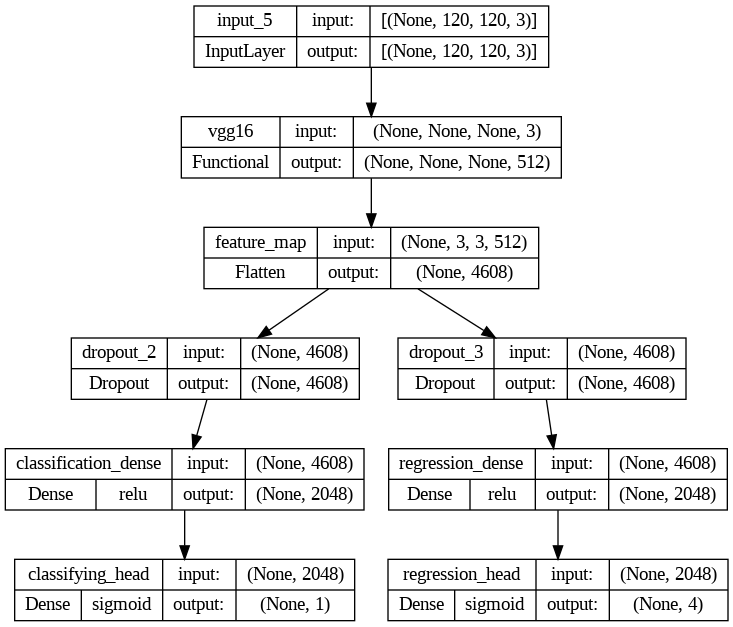

In [92]:
keras.utils.plot_model(ntr_detector, show_shapes=True, show_layer_activations=True)

# Define Losses and Optimizer

In [42]:
bpe = len(data[1]) # batches per epoch
lr_decay = (1/.75-1)/bpe

In [43]:
len(data[0]), len(data[1]), len(data[2])

(68, 428, 173)

In [93]:
lr_decay

0.0007788161993769469

## Custom loss

In [94]:
def regression_loss(y_true, y_pred):
  true_coord = y_true[:,:2]
  pred_coord = y_pred[:,:2]

  true_w = y_true[:,2]
  true_h = y_true[:,3]

  pred_w = y_pred[:,2]
  pred_h = y_pred[:,3]

  delta_coord = tf.reduce_sum(tf.square(true_coord-pred_coord))
  delta_size = tf.reduce_sum(tf.square(true_w-pred_w)+
                             tf.square(true_h-pred_h))
  return delta_coord + delta_size

In [95]:
opt = keras.optimizers.Adam(learning_rate=0.0001, weight_decay = lr_decay)
closs= keras.losses.BinaryCrossentropy()
lloss = regression_loss

In [96]:
class detect_ntr(Model):
  def __init__(self, ntr_detector, **kwargs):
    super().__init__(**kwargs)
    self.model = ntr_detector

  def compile(self, opt, loss, **kwargs):
    super().compile(**kwargs)
    self.opt = opt
    self.closs = loss[0]
    self.lloss = loss[1]

  def train_step(self, batch, **kwargs):
    x,y = batch

    with tf.GradientTape() as tape:
      classes, coords = self.model(x, training=True)

      batch_closs = self.closs(y[0], classes)
      batch_lloss = self.lloss(y[1], coords)

      total_loss = batch_lloss + 0.5 * batch_closs

      gradient = tape.gradient(total_loss, self.model.trainable_variables)
    opt.apply_gradients(zip(gradient, self.model.trainable_variables))
    return {'Loss' : total_loss, 'cLoss' : batch_closs, 'lLoss' : batch_lloss}

  def test_step(self, batch, **kwargs):
    x,y = batch

    classes, coords = self.model(x, training=True)

    batch_closs = self.closs(y[0], classes)
    batch_lloss = self.lloss(tf.cast(y[1], tf.float32), coords)

    total_loss = batch_lloss + 0.5 * batch_closs
    return {'Loss' : total_loss, 'cLoss' : batch_closs, 'lLoss' : batch_lloss}

  def call(self, x, **kwargs):
    return self.model(x, **kwargs)

In [97]:
model = detect_ntr(ntr_detector)

In [98]:
model.compile(opt, [closs, lloss])

In [99]:
test, train, val = data

In [100]:
len(train), len(test), len(val)

(428, 68, 173)

In [ ]:
train_batch = train.as_numpy_iterator()

In [ ]:
x, y = train_batch.next()

In [ ]:
y[1]

array([[0.15807843, 0.        , 0.3125098 , 0.462     ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.18819608, 0.        , 0.28239214, 0.27313724],
       [0.2509804 , 0.06666667, 0.14878431, 0.17411764],
       [0.        , 0.2575294 , 0.14741176, 0.21305883],
       [0.        , 0.        , 0.        , 0.        ],
       [0.13725491, 0.2805098 , 0.16184314, 0.19007844],
       [0.19607843, 0.4409804 , 0.178     , 0.02960784]], dtype=float32)

In [101]:
log_dir = '/content/logs_v2'
callbacks = keras.callbacks.TensorBoard(log_dir=log_dir)

## start training

In [102]:
hist = model.fit(train, epochs= 10, validation_data=val, callbacks=[callbacks])

Epoch 1/10
428/428 [==============================] - 43s 76ms/step - Loss: 0.6706 - cLoss: 0.4490 - lLoss: 0.4461 - val_Loss: 0.0911 - val_cLoss: 0.0170 - val_lLoss: 0.0826
Epoch 2/10
428/428 [==============================] - 35s 74ms/step - Loss: 0.3050 - cLoss: 0.2056 - lLoss: 0.2022 - val_Loss: 0.1279 - val_cLoss: 0.0844 - val_lLoss: 0.0857
Epoch 3/10
428/428 [==============================] - 37s 77ms/step - Loss: 0.1676 - cLoss: 0.0940 - lLoss: 0.1206 - val_Loss: 0.0225 - val_cLoss: 0.0173 - val_lLoss: 0.0139
Epoch 4/10
428/428 [==============================] - 35s 75ms/step - Loss: 0.1221 - cLoss: 0.0656 - lLoss: 0.0893 - val_Loss: 0.8319 - val_cLoss: 1.1800 - val_lLoss: 0.2419
Epoch 5/10
428/428 [==============================] - 35s 76ms/step - Loss: 0.0869 - cLoss: 0.0410 - lLoss: 0.0664 - val_Loss: 0.3351 - val_cLoss: 0.4820 - val_lLoss: 0.0941
Epoch 6/10
428/428 [==============================] - 35s 75ms/step - Loss: 0.0835 - cLoss: 0.0400 - lLoss: 0.0635 - val_Loss: 0.7

In [103]:
history = hist.history

In [81]:
history.keys()

dict_keys(['Loss', 'cLoss', 'lLoss', 'val_Loss', 'val_cLoss', 'val_lLoss'])

In [ ]:
history

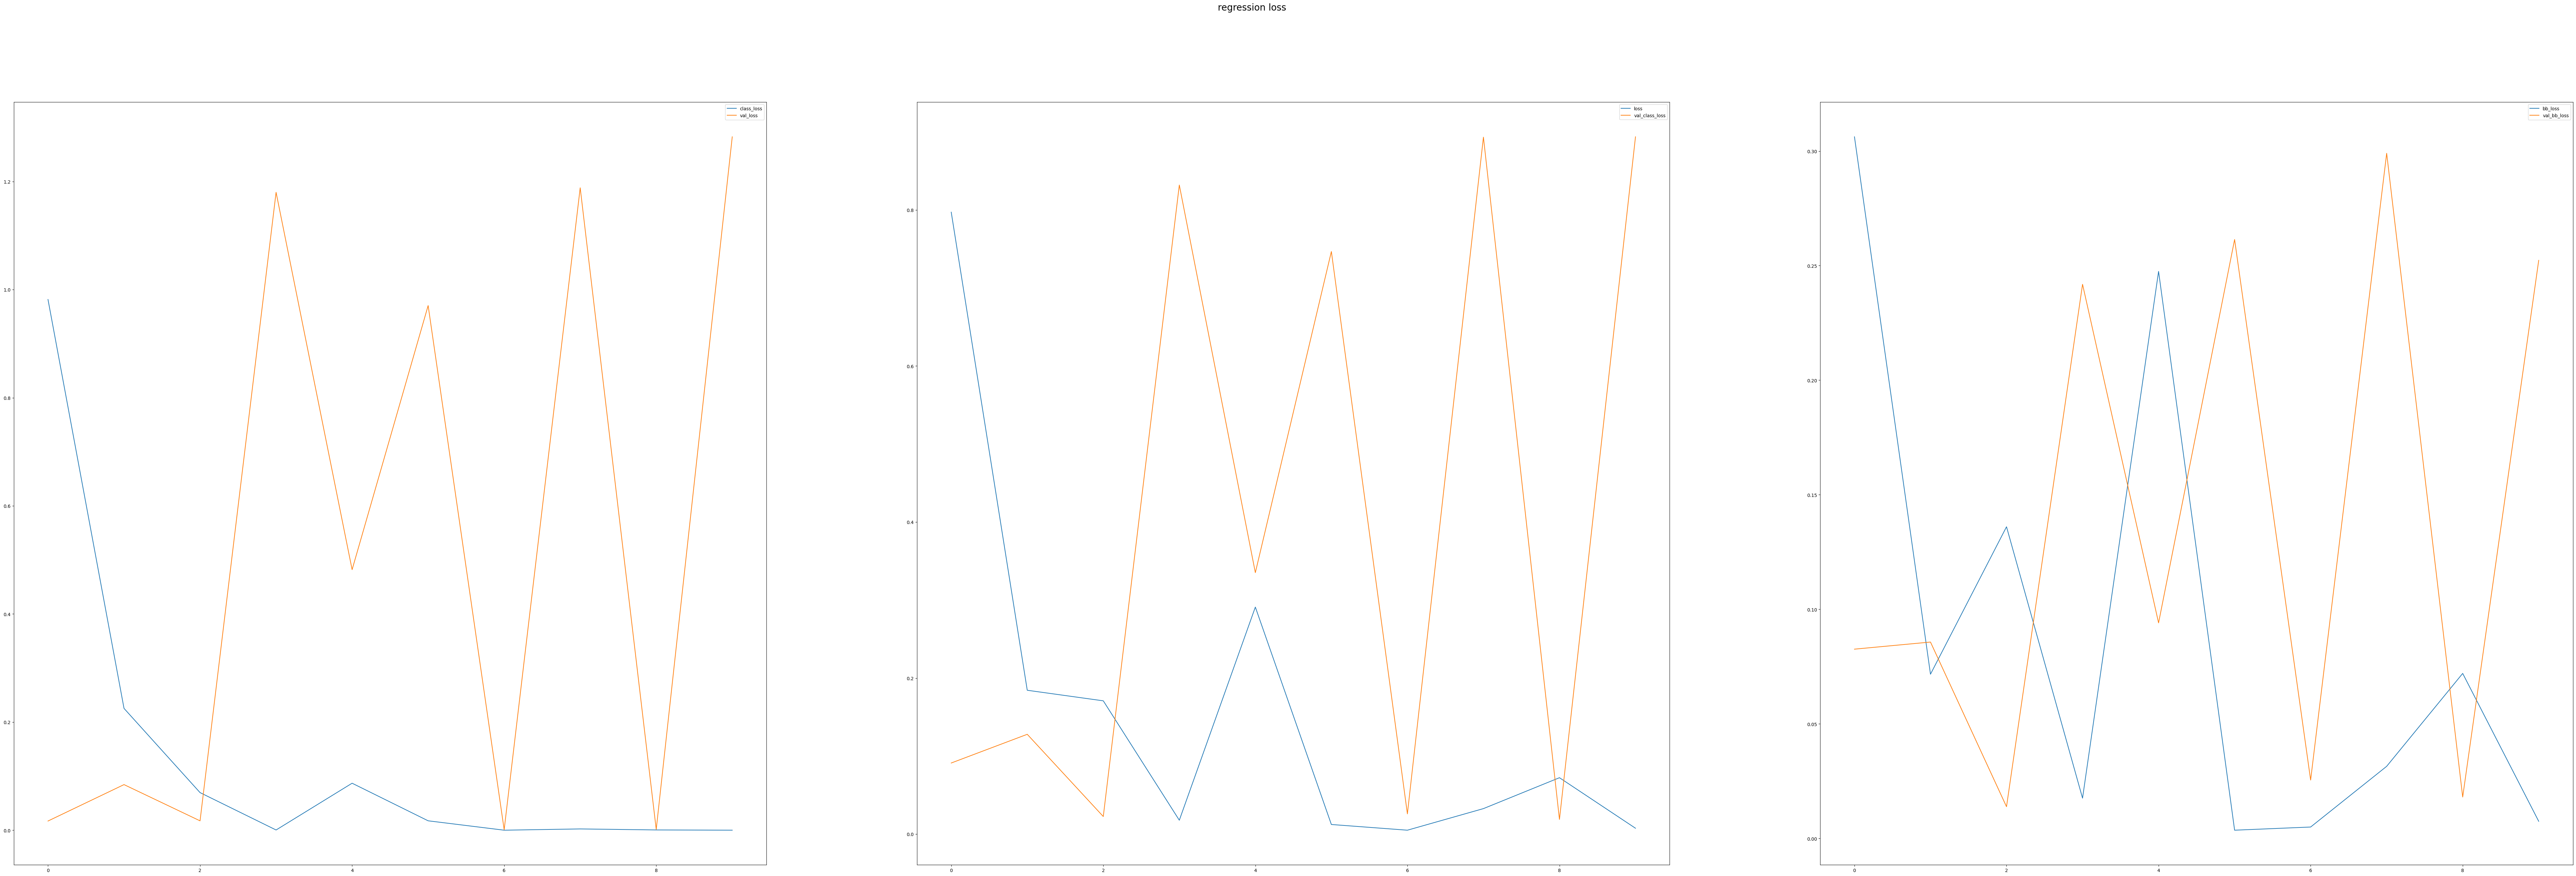

In [104]:
fig = plt.figure()
fig.set_size_inches(100, 30)

fig.add_subplot(131)
plt.plot(history['cLoss'], label='class_loss')
plt.plot(history['val_cLoss'], label='val_loss')
plt.suptitle('classification loss', fontsize = 20)
plt.legend(loc='upper right')

fig.add_subplot(132)
plt.plot(history['Loss'], label='loss')
plt.plot(history['val_Loss'], label='val_class_loss')
plt.suptitle('loss', fontsize = 20)
plt.legend(loc='upper right')

fig.add_subplot(133)
plt.plot(history['lLoss'], label='bb_loss')
plt.plot(history['val_lLoss'], label='val_bb_loss')
plt.suptitle('regression loss', fontsize = 20)
plt.legend(loc='upper right')

plt.show()

In [108]:
%load_ext tensorboard
%tensorboard --logdir '/content/logs_v2'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-06-18 08:51:05.457324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the s

In [107]:
!kill

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


# Predicting over test data

In [68]:
test_data = test.as_numpy_iterator()

In [80]:
yhat[0]

array([[0.9968483 ],
       [0.00900805],
       [0.4901819 ],
       [0.36363795],
       [0.99999404],
       [0.9998493 ],
       [0.99999964],
       [0.00438318]], dtype=float32)

1/1 [==============================] - 0s 20ms/step


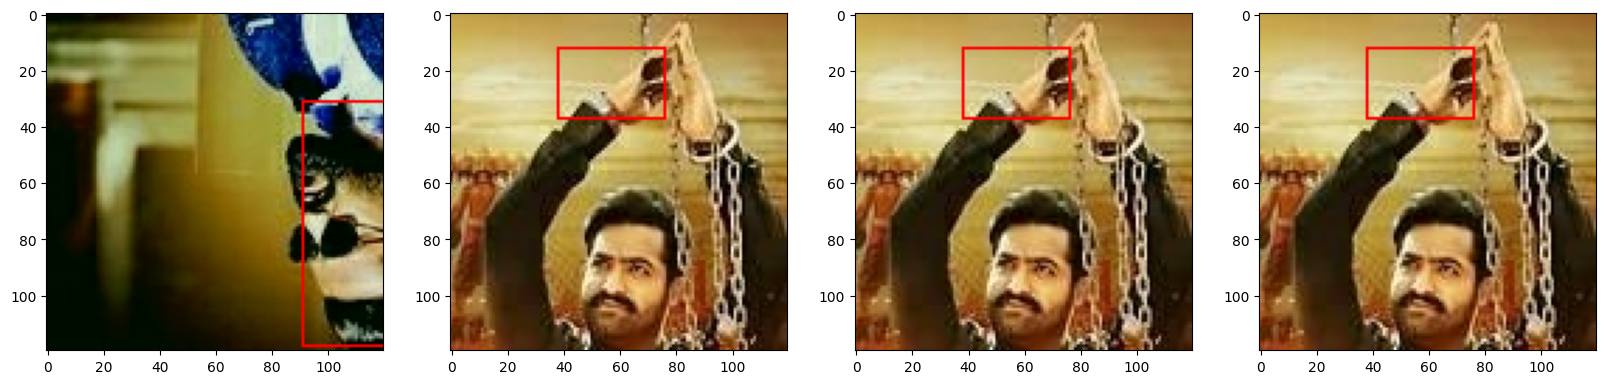

In [115]:
testing = test_data.next()
yhat = model.predict(testing[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
  img = testing[0][i]
  coord = yhat[1][i]

  if yhat[0][i]>0.9:
    det = cv2.rectangle(img, tuple(np.multiply(coord[:2], [255, 255]).astype(int)),
                  tuple(np.multiply(np.add(coord[2:],coord[:2]), [255, 255]).astype(int)), 1)
  ax[i].imshow(det)

#saving model

In [116]:
model.save('ntr_detector_v2.pb')

In [86]:
del model

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
